# Time Series with Python

© Francesco Mosconi, 2016

## Regression
- detrending
- lagged variables
- train-test split
- validation

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 11, 7

## Regression

In [2]:
df = pd.read_csv('retail_sales.csv')
df.head()

,Period,Value
0,Jan-1992,146376
1,Feb-1992,147079
2,Mar-1992,159336
3,Apr-1992,163669
4,May-1992,170068


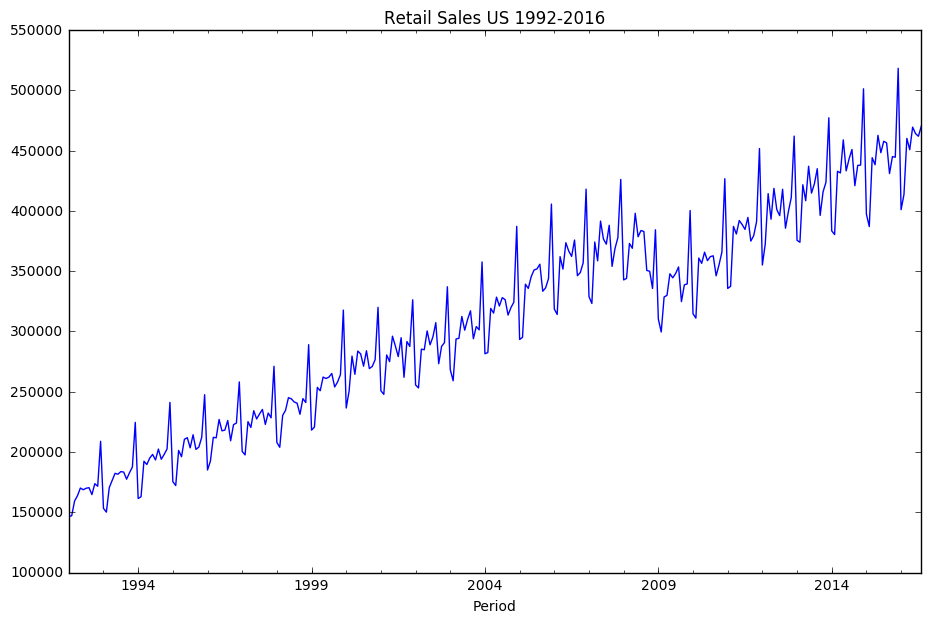

In [3]:
df = df.set_index(pd.to_datetime(df['Period'])).drop('Period', axis=1)
df.plot(legend=False)
plt.title('Retail Sales US 1992-2016')

## Rescale values

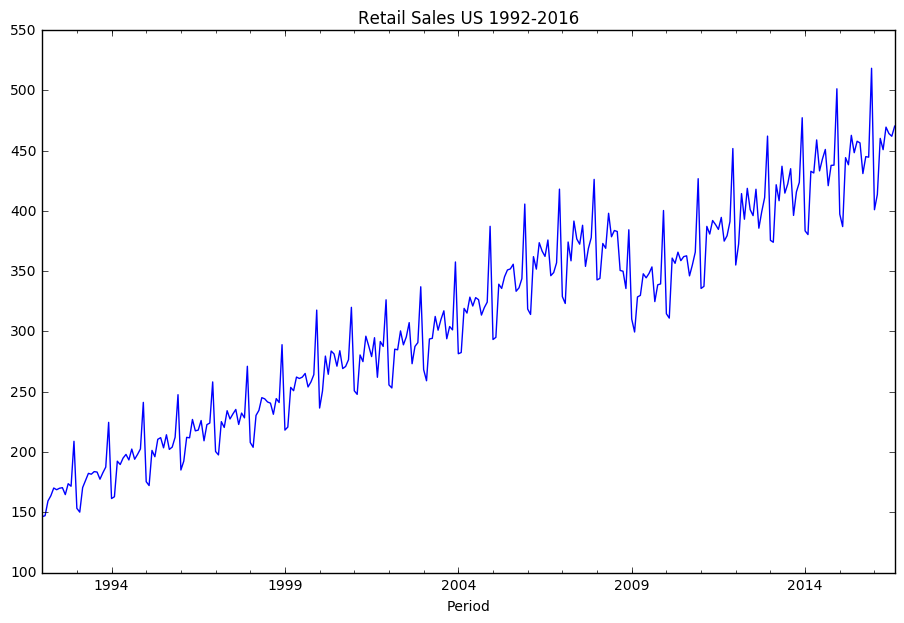

In [4]:
df /= 1e3
df.plot(legend=False)
plt.title('Retail Sales US 1992-2016')

## Julian date
Using Julian dates turns dates to a real number, making it easier to build a regression.
We also remove the date of the first day, so that dates will start from zero. Notice that Julian dates are measured in days.

In [5]:
df['Julian'] = df.index.to_julian_date() - df.index.to_julian_date().min()
df.head()

,Value,Julian
Period,,
1992-01-01,146.376,0.0
1992-02-01,147.079,31.0
1992-03-01,159.336,60.0
1992-04-01,163.669,91.0
1992-05-01,170.068,121.0


## The most important thing: split Past and Future

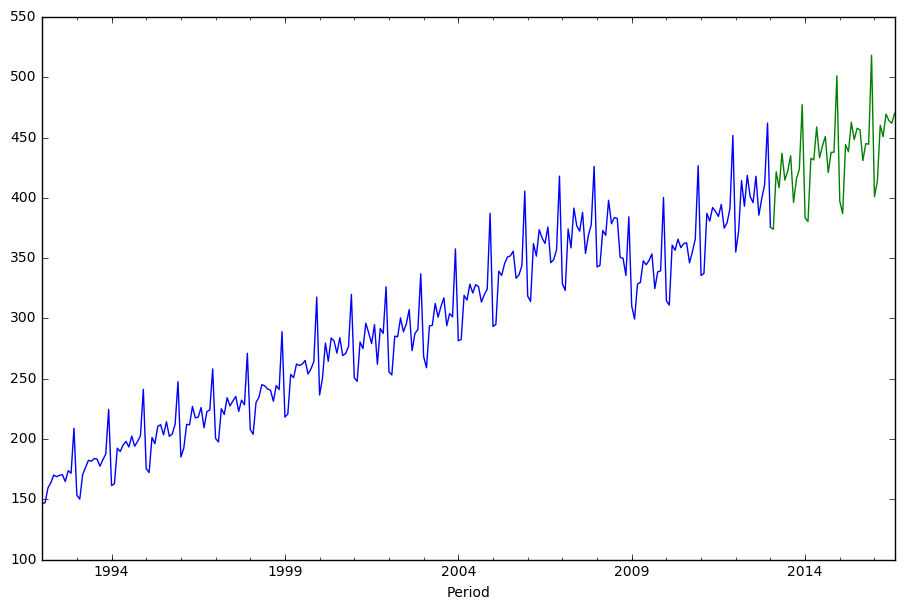

In [6]:
cutoff = pd.Timestamp('2013-01-01')
train = df.loc[:cutoff].copy()
test = df.loc[cutoff:].copy()
train['Value'].plot()
test['Value'].plot()

## Simplest trend: linear

In [7]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

X_train = train[['Julian']]
X_test = test[['Julian']]

y_train = train['Value']
y_test = test['Value']

lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
lr.score(X_test, y_test)

0.25210669635251903

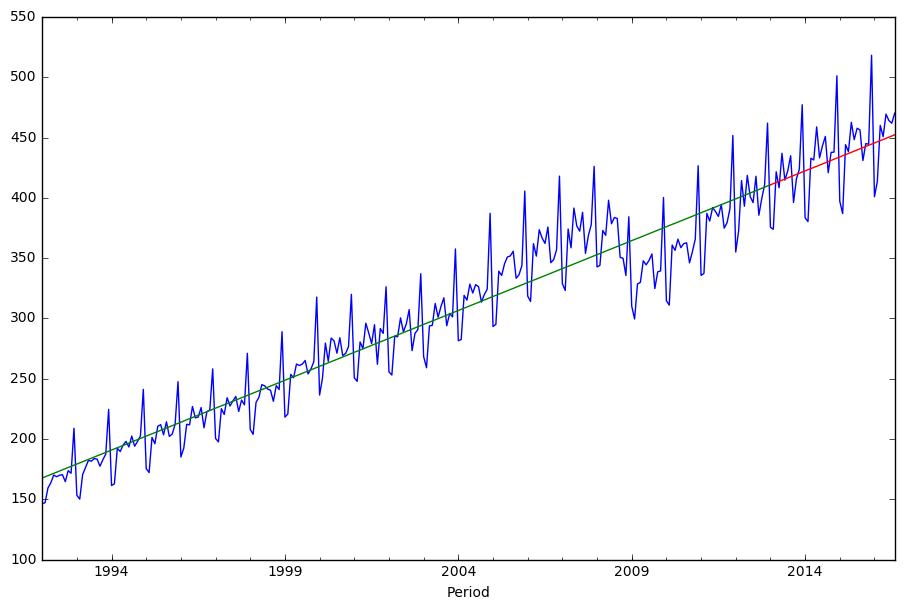

In [9]:
train['linear_prediction'] = lr.predict(X_train)
test['linear_prediction'] = lr.predict(X_test)
df['Value'].plot()
train['linear_prediction'].plot()
test['linear_prediction'].plot()

## Exercise:

Play around with the cutoff date.
- How does the regression score change?
- What happens if you move the cutoff date to before the 2008 crisis?

## Predicting the stationary component

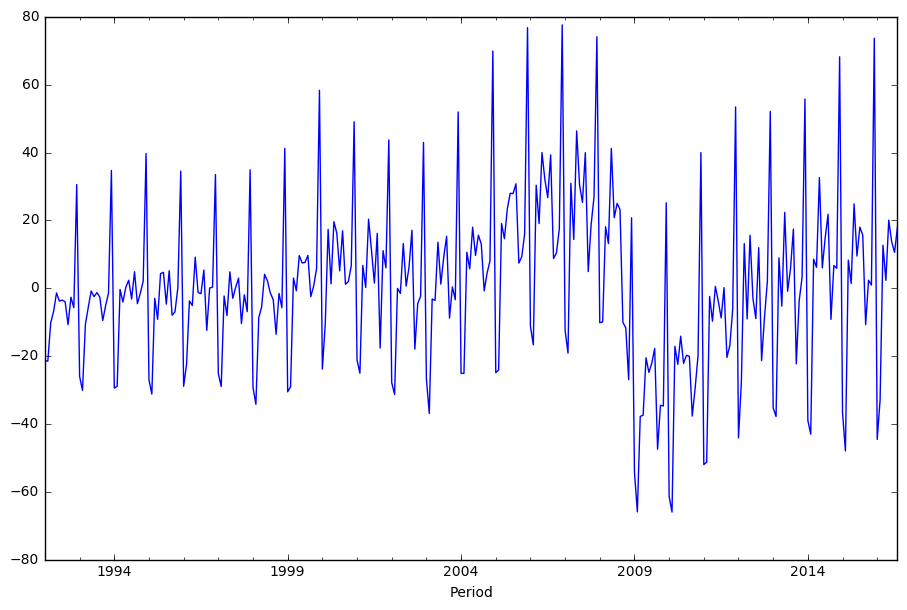

In [10]:
df['linear_prediction'] = lr.predict(df[['Julian']])
df['value_minus_linear'] = df['Value'] - df['linear_prediction'] 
df['value_minus_linear'].plot()

## Delayed variables

In [11]:
def add_shifts(tdf):
    df = tdf.copy()
    for i in xrange(1,24):
        df['shift_'+str(i)] = df['value_minus_linear'].shift(i).fillna(0)
    return df

add_shifts(df).head()

,Value,Julian,linear_prediction,value_minus_linear,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,...,shift_14,shift_15,shift_16,shift_17,shift_18,shift_19,shift_20,shift_21,shift_22,shift_23
Period,,,,,,,,,,,,,,,,,,,,,
1992-01-01,146.376,0.0,167.619096,-21.243096,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-02-01,147.079,31.0,168.601832,-21.522832,-21.243096,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-03-01,159.336,60.0,169.521165,-10.185165,-21.522832,-21.243096,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-04-01,163.669,91.0,170.503901,-6.834901,-10.185165,-21.522832,-21.243096,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-05-01,170.068,121.0,171.454936,-1.386936,-6.834901,-10.185165,-21.522832,-21.243096,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


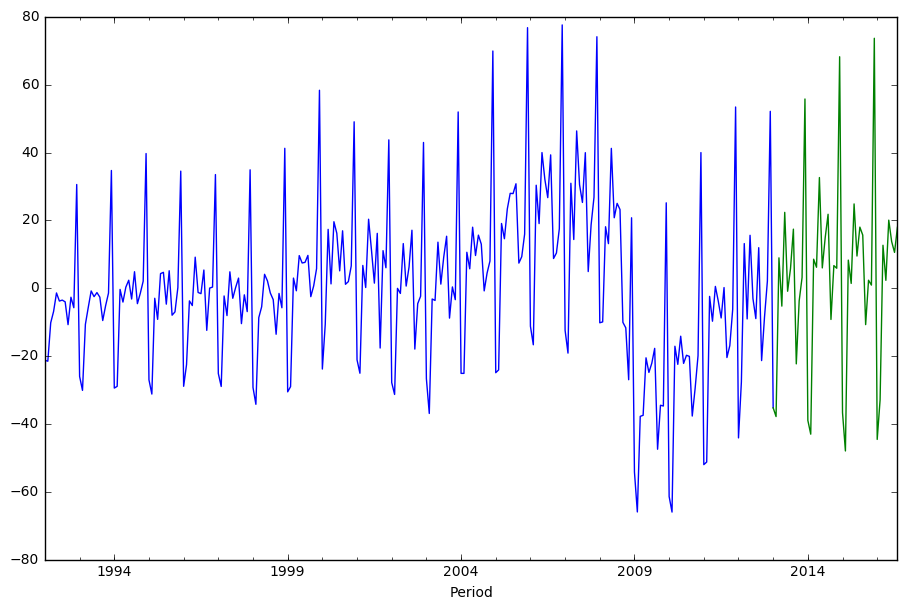

In [12]:
cutoff = pd.Timestamp('2013-01-01')
train = df.loc[:cutoff].copy()
test = df.loc[cutoff:].copy()
train['value_minus_linear'].plot()
test['value_minus_linear'].plot()

In [13]:
train = add_shifts(train)
test = add_shifts(test)

In [14]:
model = LinearRegression()

features = ['Julian'] + list(train.loc[:, 'shift_1':].columns)

print features

X_train = train[features]
X_test = test[features]

y_train = train['value_minus_linear']
y_test = test['value_minus_linear']

model.fit(X_train, y_train)

['Julian', 'shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5', 'shift_6', 'shift_7', 'shift_8', 'shift_9', 'shift_10', 'shift_11', 'shift_12', 'shift_13', 'shift_14', 'shift_15', 'shift_16', 'shift_17', 'shift_18', 'shift_19', 'shift_20', 'shift_21', 'shift_22', 'shift_23']


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

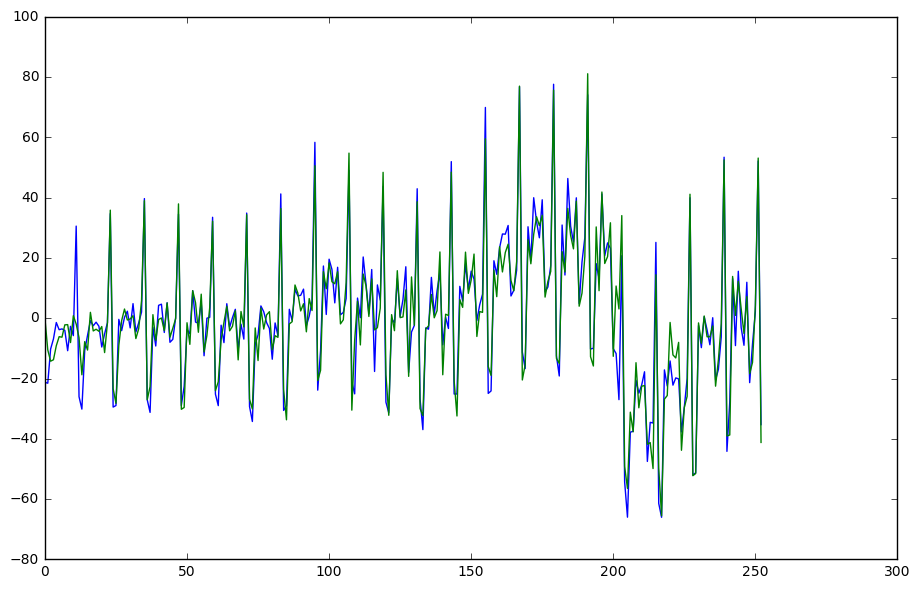

In [15]:
plt.plot(y_train.values)
plt.plot(model.predict(X_train))

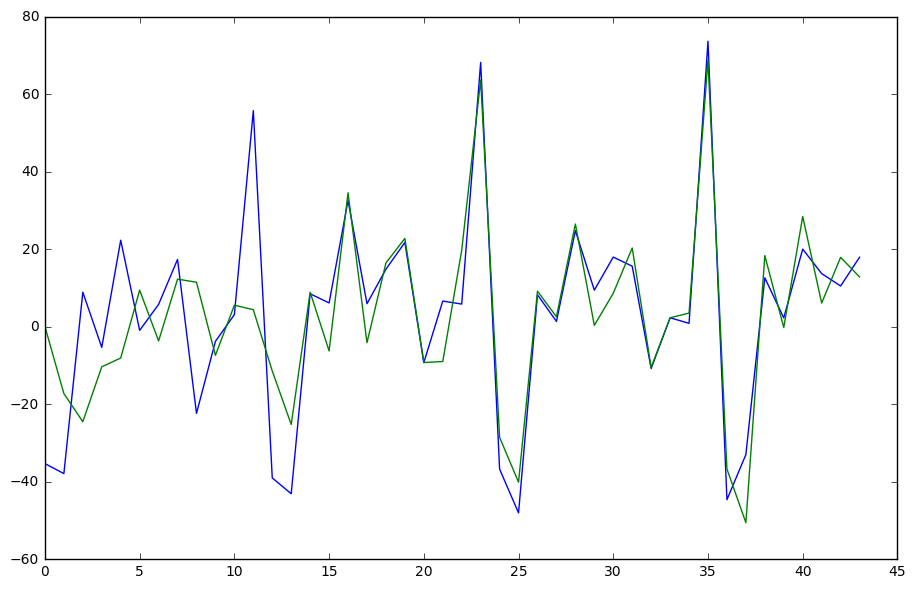

In [16]:
plt.plot(y_test.values)
plt.plot(model.predict(X_test))

first test year predictions are bad, why?

How could we improve them?

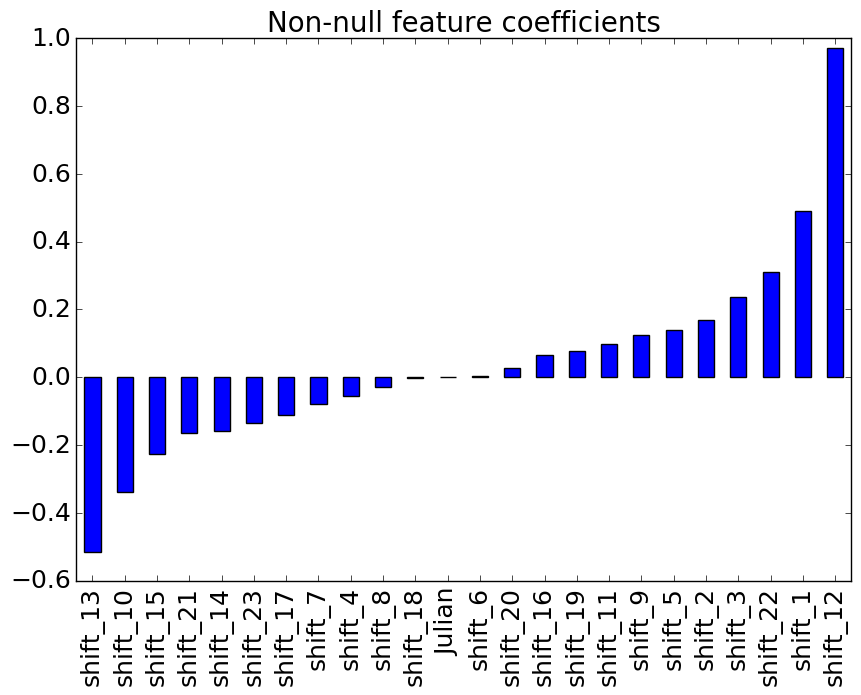

In [17]:
coefs = model.coef_[np.abs(model.coef_) > 0.]
cols = X_train.columns[np.abs(model.coef_) > 0.]

plt.figure(figsize=(10,7))
s = pd.Series(coefs, index=cols).sort_values()
s.plot(kind='bar', fontsize=18)
plt.title('Non-null feature coefficients', fontsize=20)

In [18]:
model.score(X_test, y_test)

0.66727807293444519

## Exercise

Scikit Learn offers many other regression models. Try experimenting with any of the following models and see if you can improve your test score.

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ARDRegression, BayesianRidge, ElasticNet, Hinge, Huber
from sklearn.linear_model import Lars, Lasso, LassoLars, ModifiedHuber
from sklearn.linear_model import MultiTaskElasticNet, MultiTaskLasso, OrthogonalMatchingPursuit
from sklearn.linear_model import PassiveAggressiveRegressor, RANSACRegressor, RandomizedLasso
from sklearn.linear_model import Ridge, SGDRegressor, TheilSenRegressor

## Question:

You have successfully implemented a model that is able to predict the future. Can you use it to detect anomalies? How? Could you have predicted a rare event like the 2008 crisis?

## Next steps:

- [Autoregressive models](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)
- [Bayesian Time series modeling](http://multithreaded.stitchfix.com/blog/2016/04/21/forget-arima/)
- [Recurrent neural network models](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/)